In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
from IPython.display import display
import time
from math import log
t = time.time()

Nous étudions dans ce notebook un modèle **semi-supervisé** utilisant le modèle **Naive Bayes**.

# 1. Chargement de la base Sentiment140 et de la base webscrapée

## 1.1. Base Sentiment140

In [2]:
NB_DATA_140 = 200000
NB_DATA_WEB = 50

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_140 = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)
df_140.shape

(200000, 6)

In [4]:
df_140.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
1,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
2,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
3,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
4,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
5,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
6,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
7,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
8,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
9,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


 ## 1.2. Base webscrapée

In [5]:
file = "web"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_web = pd.read_pickle(os.path.join("data", "web", file + ".bz2"))
df_web.shape

(10588, 7)

In [6]:
df_web.head(10)

,search,author,time,url,text,lang,reply
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut the f ck up about hillary s likability wh...,en,False
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,the agreed to pay former vice president to spe...,en,False
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,a series of careful financial decisions and th...,en,False
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,i agree this is useful democrats should defini...,en,False
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden s campaign in waiting includes ...,en,False
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also on fox news newt gingrich praised sen mar...,en,False
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republicans at fox news even had high praise f...,en,False
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,for every joe biden he votes for i am going to...,en,False
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,the unspoken and untrue premise of this piece ...,en,False
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,re the dem race i will vote for whoever is the...,en,False


## 1.3. Catégorisation à la main

In [7]:
df_web_cat = pd.read_pickle(os.path.join("data", "web", file + ".bz2")).sample(NB_DATA_WEB, random_state=1234).reset_index(drop=True)
df_web_cat.shape

(50, 7)

In [8]:
df_web_cat.head(10)

,search,author,time,url,text,lang,reply
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False


In [9]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate("Hello my name is Bob", lang_tgt='fr')  
print(translate_text)

Bonjour, mon nom est Bob 


In [10]:
# %%time
# temp = df_web_cat.copy()
# temp['text_trad'] = temp.text.map(lambda x: translator.translate(x, lang_tgt='fr'))
# temp.head(10)

In [11]:
# temp['sentiment'] = 0

In [12]:
# temp.to_excel(os.path.join("data", "web", "cat.xlsx"))

In [13]:
df_temp = pd.read_excel(os.path.join("data", "web", "cat_.xlsx")).drop(columns=['Unnamed: 0', 'text_trad'])
df_temp.sentiment = df_temp.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df_temp.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


In [14]:
(df_web_cat.text == df_temp.text).all()

True

In [15]:
df_web_cat['sentiment'] = df_temp.sentiment
df_web_cat.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


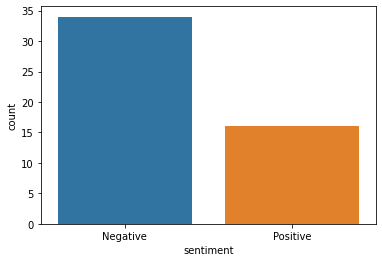

In [16]:
sns.countplot(x='sentiment', data=df_web_cat)
plt.show()

In [17]:
X_140 = df_140.text.to_list()
y_140 = df_140.sentiment.to_list()
y_140_bool = (np.array(y_140) == 'Positive').astype(int).tolist()

X_web = df_web.text.to_list()
X_web_cat = df_web_cat.text.to_list()
y_web_cat = df_web_cat.sentiment.to_list()
y_web_cat_bool = (np.array(y_web_cat) == 'Positive').astype(int).tolist()

# 2. Performances des modèles précédents

On fait attention à bien fitter le vectorizer sur les bases Sentiment140 et webscrapée 

In [18]:
class Modelisation():
    def __init__(self, X_labeled, y_labeled, X_unlabeled, X_unlabeled_cat, y_unlabeled_cat, vectorizer, model, scaling=True):
        vectorizer.fit(X_labeled+X_unlabeled)
        X_labeled = vectorizer.transform(X_labeled)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X_labeled = scaler.fit_transform(X_labeled)

        X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, train_size=0.80, random_state=1234)

        model.fit(X_train_labeled, y_train_labeled)    
        y_pred_labeled = model.predict(X_test_labeled)

        X_unlabeled_cat = vectorizer.transform(X_unlabeled_cat)
        if scaling:
            X_unlabeled_cat = scaler.transform(X_unlabeled_cat)
        y_pred_unlabeled_cat = model.predict(X_unlabeled_cat)
        
        self.X_test_labeled = X_test_labeled
        self.y_test_labeled = y_test_labeled
        self.y_pred_labeled = y_pred_labeled
        self.X_unlabeled_cat = X_unlabeled_cat
        self.y_unlabeled_cat = y_unlabeled_cat
        self.y_pred_unlabeled_cat = y_pred_unlabeled_cat
        self.vectorizer = vectorizer
        self.model = model
        self.scaling = scaling
        
        if scaling:
            self.scaler = scaler
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self, X_test, y_test, y_pred):
        metrics.plot_confusion_matrix(self.model, X_test, y_test, cmap='Blues')
        plt.show()
        
        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)        
        sc_roc_auc = metrics.roc_auc_score(y_test, self.model.predict_proba(X_test)[:, 1])        

        print(f"Accuracy : {sc_accuracy:.4f}")
        print(f"Balanced accuracy : {sc_balanced_accuracy:.4f}")
        print(f"ROC AUC : {sc_roc_auc:.4f}")
        
    def show_conf_matrix_labeled(self):
        print("\nDonnées labellisées de test (Sentiment140)")
        self.show_conf_matrix(self.X_test_labeled, self.y_test_labeled, self.y_pred_labeled)
        
    def show_conf_matrix_unlabeled(self):
        print("\nDonnées non labellisées (Webscraping labellisé à la main)")
        self.show_conf_matrix(self.X_unlabeled_cat, self.y_unlabeled_cat, self.y_pred_unlabeled_cat)
    
    def predict(self, X):
        X = self.vectorizer.transform(X)
        if self.scaling:
            X = self.scaler.transform(X)
        return self.model.predict(X)


Données labellisées de test (Sentiment140)


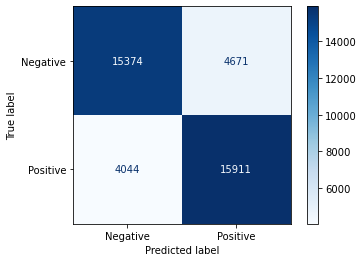

Accuracy : 0.7821
Balanced accuracy : 0.7824
ROC AUC : 0.8524

Données non labellisées (Webscraping labellisé à la main)


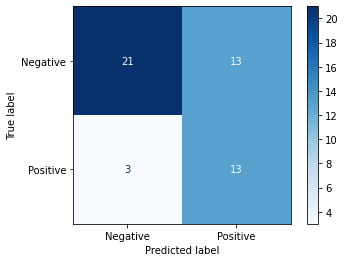

Accuracy : 0.6800
Balanced accuracy : 0.6875
ROC AUC : 0.7868
Wall time: 11 s


In [19]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000), LogisticRegression())
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


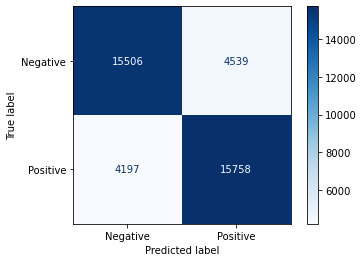

Accuracy : 0.7816
Balanced accuracy : 0.7817
ROC AUC : 0.8615

Données non labellisées (Webscraping labellisé à la main)


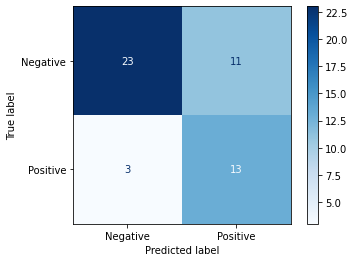

Accuracy : 0.7200
Balanced accuracy : 0.7131
ROC AUC : 0.8070
Wall time: 10.3 s


In [20]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), LogisticRegression())
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


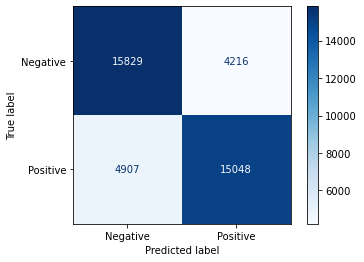

Accuracy : 0.7719
Balanced accuracy : 0.7723
ROC AUC : 0.8442

Données non labellisées (Webscraping labellisé à la main)


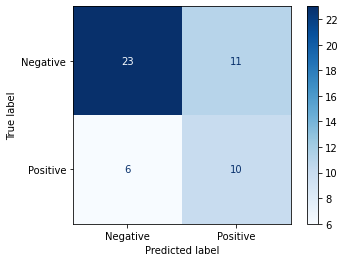

Accuracy : 0.6600
Balanced accuracy : 0.6346
ROC AUC : 0.6801
Wall time: 8.55 s


In [21]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000), MultinomialNB(alpha=1), scaling=False)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


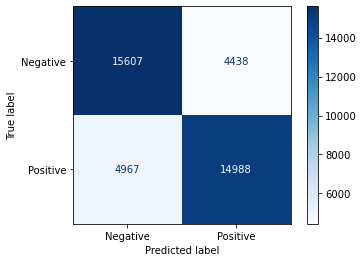

Accuracy : 0.7649
Balanced accuracy : 0.7651
ROC AUC : 0.8477

Données non labellisées (Webscraping labellisé à la main)


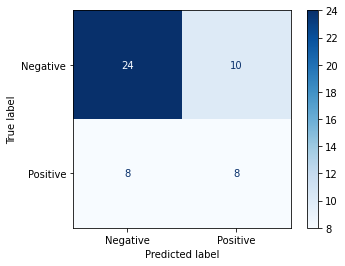

Accuracy : 0.6400
Balanced accuracy : 0.5972
ROC AUC : 0.6434
Wall time: 8.46 s


In [22]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), MultinomialNB(alpha=1), scaling=False)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

# 3. Apprentissage semi-supervisé

Nous utilisons une modification du modèle MuntinomialNB disponible sur ce projet : https://github.com/jmatayoshi/semi-supervised-naive-bayes

In [23]:
from semi_supervised_naive_bayes import MultinomialNBSS

In [24]:
class ModelisationSemi(Modelisation):
    def __init__(self, X_labeled, y_labeled_bool, X_unlabeled, X_unlabeled_cat, y_unlabeled_cat_bool, vectorizer, facteur=None, alpha=1, beta=1):
        if facteur or facteur==0:
            correction = int((len(X_labeled)/(len(X_unlabeled))) * facteur)
            X_unlabeled_fac = X_unlabeled * correction
        else:
            X_unlabeled_fac = X_unlabeled            
        
        print(f"Nombre de lignes base labellisée (Sentiment140)    : {len(X_labeled)}")
        print(f"Nombre de lignes base non labellisée (Webscraping) : {len(X_unlabeled_fac)}")    
    
        X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled_bool, train_size=0.80, random_state=1234)
    
        X_train_all = X_train_labeled + X_unlabeled_fac
        y_train_all = y_train_labeled + [-1]*len(X_unlabeled_fac)
        
        # On applique le vectorizer sur l'ensemble des données
        vectorizer.fit(X_labeled+X_unlabeled)
        X_train_all = vectorizer.transform(X_train_all)
        
        model = MultinomialNBSS(alpha=alpha, beta=beta)
        model.fit(X_train_all, y_train_all)        
        
        X_test_labeled = vectorizer.transform(X_test_labeled)    
        y_pred_labeled = model.predict(X_test_labeled)
        
        X_unlabeled_cat = vectorizer.transform(X_unlabeled_cat)
        y_pred_unlabeled_cat = model.predict(X_unlabeled_cat)
        
        self.X_test_labeled = X_test_labeled
        self.y_test_labeled = y_test_labeled
        self.y_pred_labeled = y_pred_labeled
        self.X_unlabeled_cat = X_unlabeled_cat
        self.y_unlabeled_cat = y_unlabeled_cat_bool
        self.y_pred_unlabeled_cat = y_pred_unlabeled_cat
        self.vectorizer = vectorizer
        self.model = model

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 0

Données labellisées de test (Sentiment140)


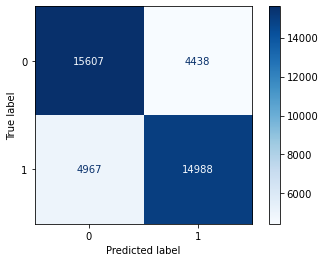

Accuracy : 0.7649
Balanced accuracy : 0.7651
ROC AUC : 0.8477

Données non labellisées (Webscraping labellisé à la main)


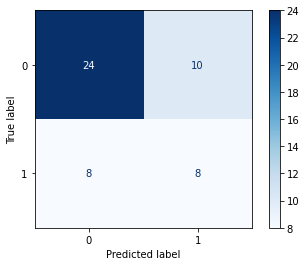

Accuracy : 0.6400
Balanced accuracy : 0.5972
ROC AUC : 0.6434
Wall time: 6.48 s


In [25]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=0)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -7635347.016495
Step 2: jll = -7635450.925285
Step 3: jll = -7635791.405360
Step 4: jll = -7636276.314308
Step 5: jll = -7636872.554824
Step 6: jll = -7637541.461260
Step 7: jll = -7638241.132196
Step 8: jll = -7638929.156158
Step 9: jll = -7639566.286332
Step 10: jll = -7640123.800748
Step 11: jll = -7640587.922633
Step 12: jll = -7640958.644079
Step 13: jll = -7641245.205586
Step 14: jll = -7641461.206237
Step 15: jll = -7641620.978395
Step 16: jll = -7641737.529493
Step 17: jll = -7641821.697493
Step 18: jll = -7641882.039321
Step 19: jll = -7641925.074963
Step 20: jll = -7641955.654186
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


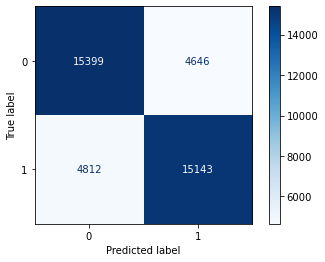

Accuracy : 0.7635
Balanced accuracy : 0.7636
ROC AUC : 0.8449

Données non labellisées (Webscraping labellisé à la main)


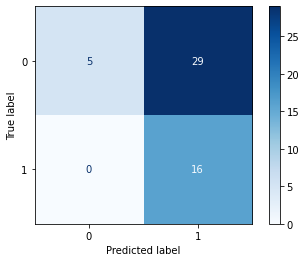

Accuracy : 0.4200
Balanced accuracy : 0.6778
ROC AUC : 0.5515
Wall time: 10.7 s


In [26]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=None)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 190584
Step 1: jll = -18601924.498412
Step 2: jll = -18599785.738596
Optimization converged after 2 iterations.

Données labellisées de test (Sentiment140)


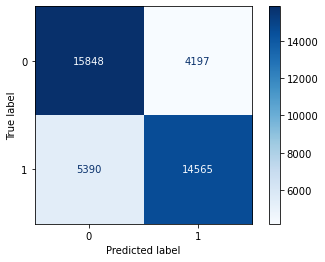

Accuracy : 0.7603
Balanced accuracy : 0.7613
ROC AUC : 0.8419

Données non labellisées (Webscraping labellisé à la main)


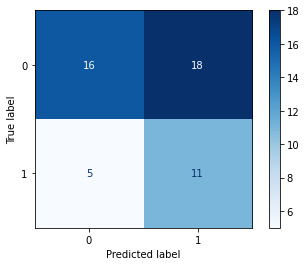

Accuracy : 0.5400
Balanced accuracy : 0.5706
ROC AUC : 0.6048
Wall time: 16.1 s


In [27]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=1)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -7635347.016495
Step 2: jll = -7635450.925285
Step 3: jll = -7635791.405360
Step 4: jll = -7636276.314308
Step 5: jll = -7636872.554824
Step 6: jll = -7637541.461260
Step 7: jll = -7638241.132196
Step 8: jll = -7638929.156158
Step 9: jll = -7639566.286332
Step 10: jll = -7640123.800748
Step 11: jll = -7640587.922633
Step 12: jll = -7640958.644079
Step 13: jll = -7641245.205586
Step 14: jll = -7641461.206237
Step 15: jll = -7641620.978395
Step 16: jll = -7641737.529493
Step 17: jll = -7641821.697493
Step 18: jll = -7641882.039321
Step 19: jll = -7641925.074963
Step 20: jll = -7641955.654186
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


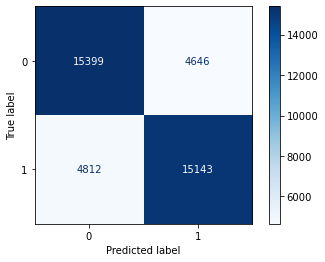

Accuracy : 0.7635
Balanced accuracy : 0.7636
ROC AUC : 0.8449

Données non labellisées (Webscraping labellisé à la main)


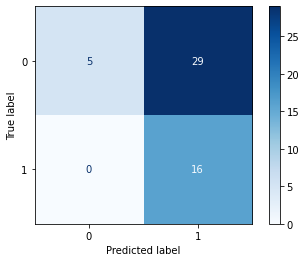

Accuracy : 0.4200
Balanced accuracy : 0.6778
ROC AUC : 0.5515
Wall time: 12.1 s


In [28]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=1)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -7639744.009019
Step 2: jll = -7639707.667722
Optimization converged after 2 iterations.

Données labellisées de test (Sentiment140)


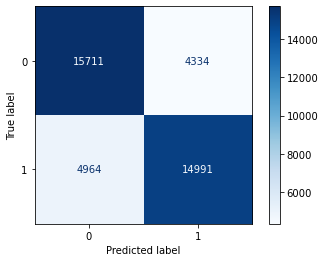

Accuracy : 0.7675
Balanced accuracy : 0.7678
ROC AUC : 0.8492

Données non labellisées (Webscraping labellisé à la main)


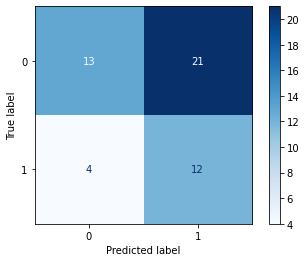

Accuracy : 0.5000
Balanced accuracy : 0.5642
ROC AUC : 0.5864
Wall time: 10.4 s


In [29]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=2)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -7678167.736241
Step 2: jll = -7677706.865898
Optimization converged after 2 iterations.

Données labellisées de test (Sentiment140)


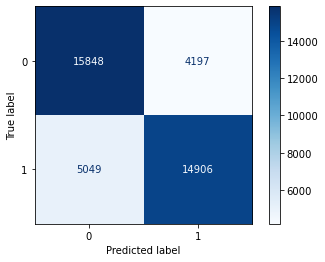

Accuracy : 0.7689
Balanced accuracy : 0.7693
ROC AUC : 0.8502

Données non labellisées (Webscraping labellisé à la main)


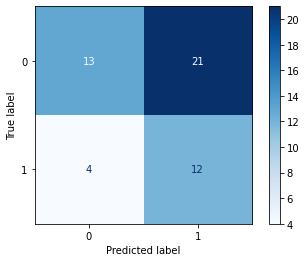

Accuracy : 0.5000
Balanced accuracy : 0.5642
ROC AUC : 0.5864
Wall time: 9 s


In [30]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=5)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -7636099.560570
Step 2: jll = -7636136.348594
Step 3: jll = -7636488.108742
Step 4: jll = -7637024.523242
Step 5: jll = -7637727.298399
Step 6: jll = -7638568.274128
Step 7: jll = -7639502.314399
Step 8: jll = -7640466.743741
Step 9: jll = -7641389.830186
Step 10: jll = -7642210.717324
Step 11: jll = -7642894.647362
Step 12: jll = -7643434.645218
Step 13: jll = -7643843.478742
Step 14: jll = -7644143.422604
Step 15: jll = -7644358.498596
Step 16: jll = -7644510.224434
Step 17: jll = -7644616.040683
Step 18: jll = -7644689.253454
Step 19: jll = -7644739.630610
Step 20: jll = -7644774.164034
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


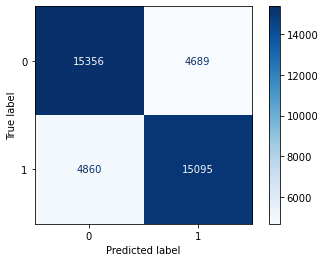

Accuracy : 0.7613
Balanced accuracy : 0.7613
ROC AUC : 0.8424

Données non labellisées (Webscraping labellisé à la main)


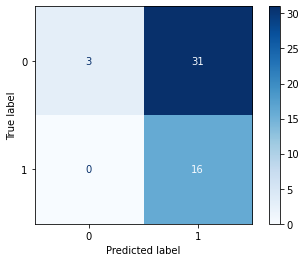

Accuracy : 0.3800
Balanced accuracy : 0.6702
ROC AUC : 0.5386
Wall time: 10.4 s


In [31]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=1.5)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

# 4. Résultats


Données labellisées de test (Sentiment140)


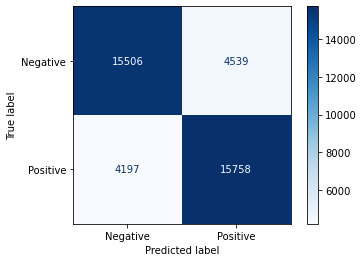

Accuracy : 0.7816
Balanced accuracy : 0.7817
ROC AUC : 0.8615

Données non labellisées (Webscraping labellisé à la main)


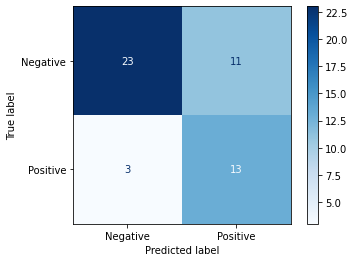

Accuracy : 0.7200
Balanced accuracy : 0.7131
ROC AUC : 0.8070
Wall time: 9.6 s


In [32]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), LogisticRegression())
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

In [33]:
%%time
resul = m.predict(X_web)

Wall time: 334 ms


In [34]:
resul

array(['Positive', 'Positive', 'Positive', ..., 'Negative', 'Positive',
       'Negative'], dtype='<U8')

In [35]:
df_web['sentiment'] = resul
df_web.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut the f ck up about hillary s likability wh...,en,False,Positive
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,the agreed to pay former vice president to spe...,en,False,Positive
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,a series of careful financial decisions and th...,en,False,Positive
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,i agree this is useful democrats should defini...,en,False,Positive
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden s campaign in waiting includes ...,en,False,Positive
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also on fox news newt gingrich praised sen mar...,en,False,Negative
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republicans at fox news even had high praise f...,en,False,Positive
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,for every joe biden he votes for i am going to...,en,False,Positive
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,the unspoken and untrue premise of this piece ...,en,False,Positive
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,re the dem race i will vote for whoever is the...,en,False,Positive


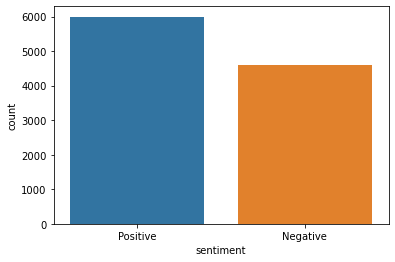

In [36]:
sns.countplot(x='sentiment', data=df_web)
plt.show()

In [37]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:02:22
